In [66]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#from matplotlib import colormaps
from tqdm.notebook import tqdm
import pickle

import utils_string as uts
import utils as ut
import utils_phase_diagr as ut_pd

### Testing the generation of strings with desired recruited number and affinities

In [ ]:
R = 500
string_model = uts.TT_string(N_tot=10**6, L_string=30, N_recruit=100)

logts_mean, logts_std, N_recrs = [], [], []
progress = tqdm(total=R)
for _ in range(R):
    recruit_strings, h_recruit, logtaus = string_model.gen_and_recruit_string()
    logts_mean.append(np.mean(logtaus))
    logts_std.append(np.std(logtaus))
    N_recrs.append(len(h_recruit))
    progress.update(1)

  0%|          | 0/500 [00:00<?, ?it/s]

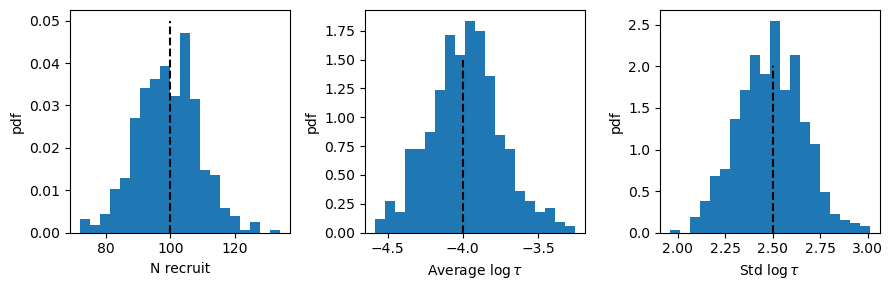

In [23]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(9,3))

ax1.set_xlabel('N recruit')
ax1.set_ylabel('pdf')
ax1.hist(N_recrs, bins=20, density=True)
Nr = string_model.N_recr
ax1.plot([Nr, Nr], [0, 1/np.sqrt(Nr)/2], c='k', ls='--')

ax2.set_xlabel(r'Average $\log \tau$')
ax2.set_ylabel('pdf')
ax2.hist(logts_mean, bins=20, density=True)
ax2.plot([-4, -4], [0, 1.5], c='k', ls='--')

ax3.set_xlabel(r'Std $\log \tau$')
ax3.set_ylabel('pdf')
ax3.hist(logts_std, bins=20, density=True)
ax3.plot([2.5, 2.5], [0, 2], c='k', ls='--')

plt.tight_layout()

### Genereting an ensemble of recruited binary clones at given string-model parameters

In [ ]:
string_model = uts.TT_string(N_tot=10**7, L_string=30, N_recruit=100)

R_string = 1000
string_ens, logtau_ens = [], []
progress = tqdm(total=R_string)
for _ in range(R_string):
    recruit_strings, h_recruit, logtaus = string_model.gen_and_recruit_string()
    string_ens.append(recruit_strings)
    logtau_ens.append(logtaus)
    progress.update(1)

with open(f'out_data/string_model/string_ensamble.pkl', 'wb') as f:
    pickle.dump((string_ens, logtau_ens), f)

sr = pd.Series(string_model.get_pars())
sr.to_csv('out_data/string_model/string_params.tsv', sep='\t', header=None)

  0%|          | 0/1000 [00:00<?, ?it/s]

### Computing beta0 at constant time of max expansion 

In [ ]:
def get_av_t_Tmax(alpha0, beta0, R):
    ts = []
    for _ in range(R):
        logtaus = logtau_ens[np.random.randint(0, len(logtau_ens))]
        pars = ut.TT_params(np.exp(logtaus), alpha0=alpha0, beta0=beta0)
        times, T_trajs, _, _ = ut.run_setting(pars, ut.tau_sampler_lognorm(), 5000, 'adapt', traj_steps=50)
        T_tot = np.sum(T_trajs, axis=1)
        ts.append(times[np.argmax(T_tot)])
    return np.mean(ts)

with open(f'out_data/string_model/string_ensamble.pkl', 'rb') as f:
    string_ens, logtau_ens = pickle.load(f)

R_beta0 = 100
t_T_max = 9
t_T_max_tol = 0.1
alpha0s = np.logspace(-6, -3, 50)

In [ ]:
beta0s = []
progress = tqdm(total=len(alpha0s))
for a0 in alpha0s:
    func = lambda x : get_av_t_Tmax(a0, x, R_beta0) - t_T_max
    beta0s.append(ut.bisection(func, 0.8, 2, t_T_max_tol))
    progress.update(1)

with open(f'out_data/string_model/a0s_b0s.pkl', 'wb') as f:
    pickle.dump((alpha0s, beta0s), f)

# Export params as well
pars = pd.read_csv('out_data/string_model/string_params.tsv', sep='\t', index_col=0, header=None)
sr = pd.Series({'R_beta0':R_beta0, 't_T_max':t_T_max, 't_T_max_tol':t_T_max_tol}, name=1)
pd.concat((pars, sr)).to_csv('out_data/string_model/string_params.tsv', sep='\t', header=None)


  0%|          | 0/50 [00:00<?, ?it/s]

You have not assumed right a and b in bisection:
f(a)=-0.10999999999999943, f(b)=-2.6050000000000004
You have not assumed right a and b in bisection:
f(a)=-0.875, f(b)=-2.425
You have not assumed right a and b in bisection:
f(a)=-1.4900000000000002, f(b)=-2.6950000000000003


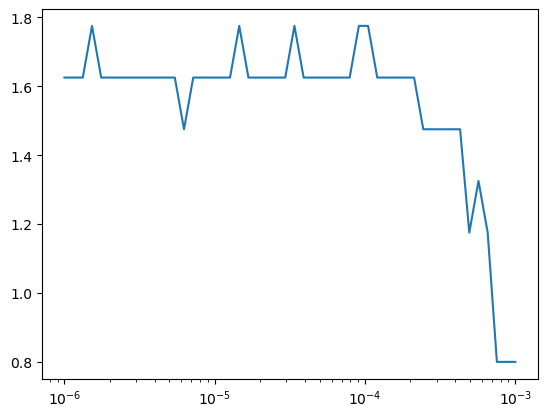

In [30]:
plt.xscale('log')
plt.plot(alpha0s, beta0s)

### Generating abundance trajectories for each alpha0-beta0

In [101]:
with open(f'out_data/string_model/string_ensamble.pkl', 'rb') as f:
    string_ens, logtau_ens = pickle.load(f)

with open(f'out_data/string_model/a0s_b0s.pkl', 'rb') as f:
    alpha0s, beta0s = pickle.load(f)

pars = pd.read_csv('out_data/string_model/string_params.tsv', sep='\t', header=None, index_col=0)[1].to_dict()
string_model = uts.TT_string(N_tot=pars['N_tot'], L_string=int(pars['L_string']), N_recruit=pars['N_recruit'])

R_traj = 200
mem_time = 30
dt = 0.005
n_time_steps = int(mem_time / dt)

In [3]:
string_ids_ens, Ts_final_ens = [], []

progress = tqdm(total=len(alpha0s))
for i in range(len(alpha0s)):

    string_aux, Ts_aux = [], []
    for _ in range(R_traj):
        
        # Sampling on id of the generated recruited strings
        i_string_ens = np.random.randint(0, len(logtau_ens))
        string_aux.append(i_string_ens)

        # Generating a trajectory until memory
        pars = ut.TT_params(np.exp(logtau_ens[i_string_ens]), alpha0=alpha0s[i], beta0=beta0s[i])
        _, T_trajs, _, _ = ut.run_setting(pars, ut.tau_sampler_lognorm(), n_time_steps, dt, traj_steps=50)
        Ts_aux.append(T_trajs[-1])

    string_ids_ens.append(string_aux)
    Ts_final_ens.append(Ts_aux)
    progress.update(1)
    

with open(f'out_data/string_model/Ts_final.pkl', 'wb') as f:
    pickle.dump((string_ids_ens, Ts_final_ens), f)

# Export params as well
pars = pd.read_csv('out_data/string_model/string_params.tsv', sep='\t', index_col=0, header=None)
sr = pd.Series({'R_traj':R_traj, 'mem_time':mem_time, 'dt':dt}, name=1)
pd.concat((pars, sr)).to_csv('out_data/string_model/string_params.tsv', sep='\t', header=None)

  0%|          | 0/50 [00:00<?, ?it/s]

In [249]:
def comp_coverage_h_norm(strings, abunds, target_string):
    L = len(target_string)
    h_dists = uts.comp_h_dist(strings, target_string)
    return np.sum(abunds*(L - h_dists)) / np.sum(abunds)

def comp_coverage_h(strings, abunds, target_string):
    L = len(target_string)
    h_dists = uts.comp_h_dist(strings, target_string)
    return np.sum(abunds*(L - h_dists))

def comp_coverage_tau_norm(strings, abunds, target_string):
    h_dists = uts.comp_h_dist(strings, target_string)
    logtaus = string_model.get_logtau(h_dists)
    return np.sum(abunds*np.exp(logtaus)) / np.sum(abunds)


def compute_inv_simps(Ts_mat):
    """
    Compute the inverse Simpson's index for a list of audaces arrays.
    It discards abundances smaller than 1.
    """
    T_freqs_mat = [T / np.sum(T) for T in Ts_mat]
    inv_simps = np.array([1 / np.sum(freqs**2) for freqs in T_freqs_mat])
    inv_simps = inv_simps[~np.isnan(inv_simps)]
    inv_simps = inv_simps[~np.isinf(inv_simps)]
    return np.mean(inv_simps)

In [210]:
with open(f'out_data/string_model/string_ensamble.pkl', 'rb') as f:
    string_ens, logtau_ens = pickle.load(f)

with open(f'out_data/string_model/a0s_b0s.pkl', 'rb') as f:
    alpha0s, beta0s = pickle.load(f)

with open(f'out_data/string_model/Ts_final.pkl', 'rb') as f:
    string_ids_ens, Ts_final_ens = pickle.load(f)

pars = pd.read_csv('out_data/string_model/string_params.tsv', sep='\t', header=None, index_col=0)[1].to_dict()

In [250]:
Rt = int(pars['R_traj'])
muts = [[], [0], np.arange(3), np.arange(10)]
cover_h, covers_h_norm, covers_tau_norm = [], [], []
T_tots, inv_simpss = [], []

for i in range(len(alpha0s)):
    strings = [string_ens[k] for k in string_ids_ens[i]]
    logtaus = [logtau_ens[k] for k in string_ids_ens[i]]

    cover_h_aux, covers_h_norm_aux, covers_tau_norm_aux = [], [], []
    for mut in muts:
        a_mut = np.zeros(int(pars['L_string']))
        a_mut[mut] = 1
        cs = [comp_coverage_h(strings[k], Ts_final_ens[i][k], a_mut) for k in range(Rt)]
        cover_h_aux.append(np.mean(cs))
        cs = [comp_coverage_h_norm(strings[k], Ts_final_ens[i][k], a_mut) for k in range(Rt)]
        covers_h_norm_aux.append(np.mean(cs))
        cs = [comp_coverage_tau_norm(strings[k], Ts_final_ens[i][k], a_mut) for k in range(Rt)]
        covers_tau_norm_aux.append(np.mean(cs))

    cover_h.append(cover_h_aux)
    covers_h_norm.append(covers_h_norm_aux)
    covers_tau_norm.append(covers_tau_norm_aux)

    T_tots.append(np.mean( [np.sum(Ts_final_ens[i][r]) for r in range(Rt)] ))
    inv_simpss.append(compute_inv_simps(Ts_final_ens[i]))

cover_h, covers_h_norm, covers_tau_norm = np.array(cover_h), np.array(covers_h_norm), np.array(covers_tau_norm)



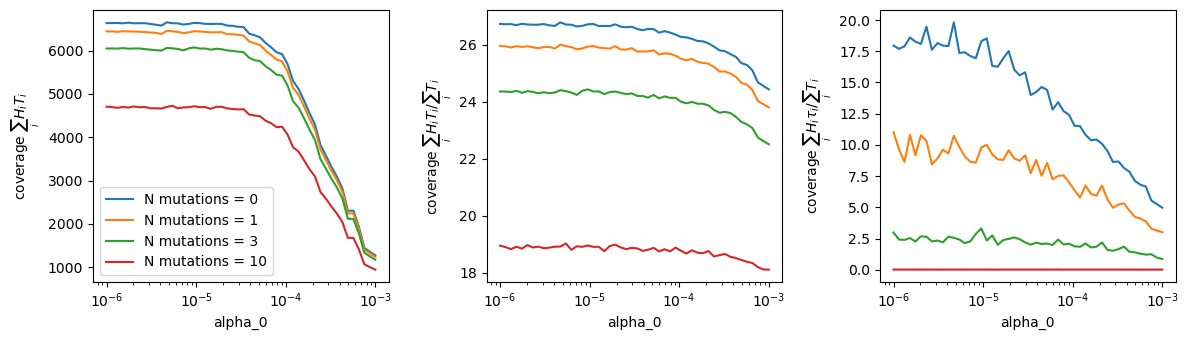

In [251]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(12,3.5))

for ax in (ax1, ax2, ax3):
    ax.set_xscale('log')
    ax.set_xlabel('alpha_0')

ax1.set_ylabel(r'coverage $\sum_i H_i T_i$')
for i, mut in enumerate(muts):
    ax1.plot(alpha0s, cover_h[:,i], label=f'N mutations = {len(mut)}')
ax1.legend()

ax2.set_ylabel(r'coverage $\sum_i H_i T_i / \sum_i T_i$')
for i, mut in enumerate(muts):
    ax2.plot(alpha0s, covers_h_norm[:,i], label=f'N mutations = {len(mut)}')

ax3.set_ylabel(r'coverage $\sum_i H_i \tau_i / \sum_i T_i$')
for i, mut in enumerate(muts):
    ax3.plot(alpha0s, covers_tau_norm[:,i], label=f'N mutations = {len(mut)}')

plt.tight_layout()


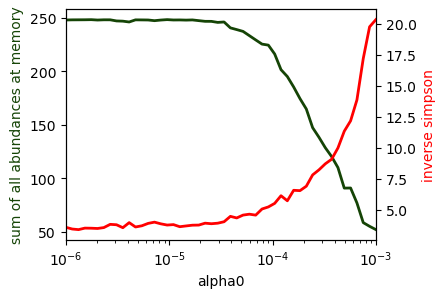

In [252]:
fig, ax1 = plt.subplots(figsize=(4,3))

ax1.set_xscale('log')
ax1.set_xlabel('alpha0')
ax1.set_xlim(alpha0s[0], alpha0s[-1])

c1, c2 = '#154406', 'r'
ax2 = ax1.twinx()

# Create a Rectangle patch
factors = np.array(T_tots) / 100

ax1.set_ylabel('sum of all abundances at memory', color=c1)
ax1.plot(alpha0s, np.array(T_tots), c=c1, lw=2)
#ax1.set_ylim(1, max(factors)+0.2)

ax2.set_ylabel('inverse simpson', color=c2)
ax2.plot(alpha0s, inv_simpss, c=c2, lw=2)

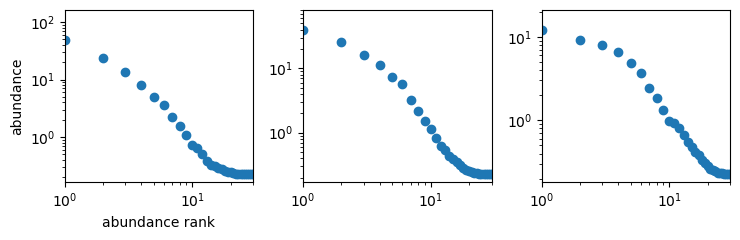

In [ ]:
i_alphas = [0, 35, 45]

fig, axs = plt.subplots(1, len(i_alphas), figsize=(len(i_alphas)*2.5, 2.5))

axs[0].set_xlabel('abundance rank')
axs[0].set_ylabel('abundance')

for i, ax in enumerate(axs):
    i_alpha = i_alphas[i]

    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlim(1, 30)

    av_T_rank, T_rank_count = np.zeros(100), np.zeros(100)
    inv_simps = 0
    for Ts in Ts_final_ens[i_alpha]:
        rank = np.argsort(Ts)[::-1][:min(len(Ts), 100)]
        ranked_Ts = np.array(Ts[rank])
        av_T_rank[:len(rank)] += ranked_Ts
        T_rank_count[:len(rank)] += 1

    av_T_rank /= T_rank_count
    ax.scatter(np.arange(100), av_T_rank)

    plt.tight_layout()

In [ ]:
i_alphas = [0, 35, 45]

fig, axs = plt.subplots(1, len(i_alphas), figsize=(len(i_alphas)*2.5, 2.5))

axs[0].set_xlabel('abundance rank')
axs[0].set_ylabel('affinity, tau')

for i, ax in enumerate(axs):
    i_alpha = i_alphas[i]

    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlim(1, 30)

    av_T_rank, T_rank_count = np.zeros(100), np.zeros(100)
    inv_simps = 0
    for Ts in Ts_final_ens[i_alpha]:
        rank = np.argsort(Ts)[::-1][:min(len(Ts), 100)]
        ranked_Ts = np.array(Ts[rank])
        av_T_rank[:len(rank)] += ranked_Ts
        T_rank_count[:len(rank)] += 1

    av_T_rank /= T_rank_count
    ax.scatter(np.arange(100), av_T_rank)

    plt.tight_layout()

np.float64(1.0)

In [158]:
Rt = int(pars['R_traj'])
all_Ts = []

for i in range(len(alpha0s)):
    all_T = []
    for Ts in Ts_final_ens[i]: all_T.extend(Ts)
    all_Ts.append(all_T)


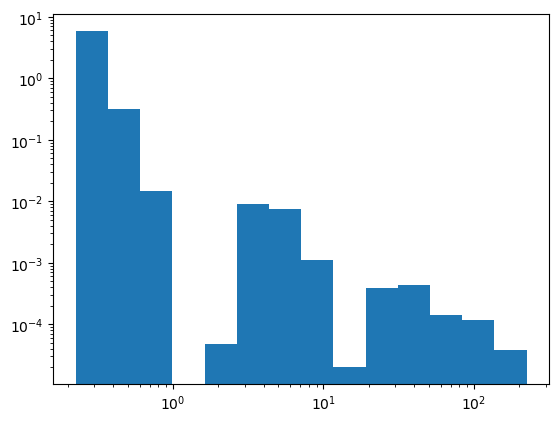

In [164]:
ids = [0]

plt.loglog()
for i in ids:
    bins = np.logspace(min(np.log10(all_Ts[i])), max(np.log10(all_Ts[i])), 15)
    plt.hist(all_Ts[i], density=True, bins=bins)


-3.0612244897959187


(array([83.,  0.,  0., 10.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  2.,
         1.]),
 array([0.22583831, 0.29399285, 0.3827154 , 0.49821306, 0.64856614,
        0.84429349, 1.09908835, 1.43077641, 1.86256286, 2.42465585,
        3.15637992, 4.10892712, 5.3489385 , 6.96316637, 9.06454351]),
 <BarContainer object of 14 artists>)

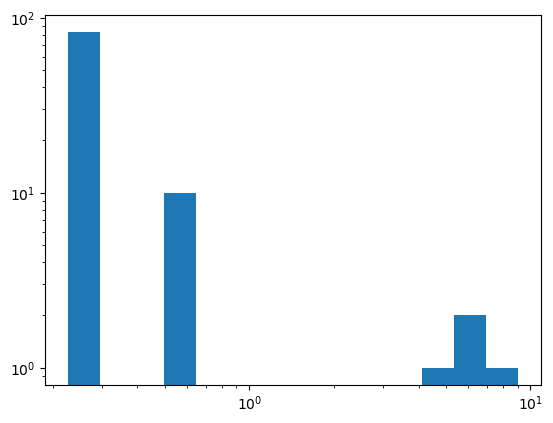

In [ ]:
i = 48
r = 13
print(np.log10(alpha0s[i]))

plt.loglog()
bins = np.logspace(min(np.log10(Ts_final_ens[i][r])), max(np.log10(Ts_final_ens[i][r])), 15)
plt.hist(Ts_final_ens[i][r], bins=bins)